<a href="https://colab.research.google.com/github/CharlesSnt/PFE/blob/main/MLP_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.interpolate import griddata
from itertools import product, combinations
import time

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# -----------------------------
# Physics-Informed Neural Network
# -----------------------------
class PhysicsInformedNN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers_list = layers
        self.network = self._build_network(layers)
        self._initialize_weights()

        # Paramètres à identifier (lambda_1 et lambda_2)
        self.lambda_1 = nn.Parameter(torch.tensor([0.0], dtype=torch.float32))
        self.lambda_2 = nn.Parameter(torch.tensor([0.0], dtype=torch.float32))

    def _build_network(self, layers):
        modules = []
        for i in range(len(layers) - 2):
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))
        return nn.Sequential(*modules)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, y, t):
        # Normalisation des entrées [-1, 1]
        inputs = torch.cat([x, y, t], dim=1)

        # Sortie du réseau: [psi, p]
        output = self.network(inputs)
        psi = output[:, 0:1]
        p = output[:, 1:2]

        # Calcul de u et v à partir de psi
        u = autograd.grad(psi.sum(), y, create_graph=True)[0]
        v = -autograd.grad(psi.sum(), x, create_graph=True)[0]

        return u, v, p, psi


# -----------------------------
# Calcul des résidus de Navier-Stokes
# -----------------------------
def compute_pde_residuals(model, x, y, t):
    """
    Calcule les résidus f_u et f_v pour l'équation de Navier-Stokes
    avec les paramètres lambda_1 et lambda_2 à identifier
    """
    u, v, p, _ = model(x, y, t)

    lambda_1 = model.lambda_1
    lambda_2 = model.lambda_2

    # Dérivées de u
    u_t = autograd.grad(u.sum(), t, create_graph=True)[0]
    u_x = autograd.grad(u.sum(), x, create_graph=True)[0]
    u_y = autograd.grad(u.sum(), y, create_graph=True)[0]
    u_xx = autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_yy = autograd.grad(u_y.sum(), y, create_graph=True)[0]

    # Dérivées de v
    v_t = autograd.grad(v.sum(), t, create_graph=True)[0]
    v_x = autograd.grad(v.sum(), x, create_graph=True)[0]
    v_y = autograd.grad(v.sum(), y, create_graph=True)[0]
    v_xx = autograd.grad(v_x.sum(), x, create_graph=True)[0]
    v_yy = autograd.grad(v_y.sum(), y, create_graph=True)[0]

    # Dérivées de p
    p_x = autograd.grad(p.sum(), x, create_graph=True)[0]
    p_y = autograd.grad(p.sum(), y, create_graph=True)[0]

    # Résidus des équations de Navier-Stokes
    f_u = u_t + lambda_1 * (u * u_x + v * u_y) + p_x - lambda_2 * (u_xx + u_yy)
    f_v = v_t + lambda_1 * (u * v_x + v * v_y) + p_y - lambda_2 * (v_xx + v_yy)

    return f_u, f_v, u, v, p


# -----------------------------
# Loss function
# -----------------------------
def compute_loss(model, x, y, t, u_true, v_true):
    """
    Loss = MSE(u,v données) + MSE(résidus PDE)
    """
    f_u, f_v, u_pred, v_pred, _ = compute_pde_residuals(model, x, y, t)

    # Loss sur les données
    loss_u = torch.mean((u_true - u_pred)**2)
    loss_v = torch.mean((v_true - v_pred)**2)

    # Loss sur les résidus PDE
    loss_f_u = torch.mean(f_u**2)
    loss_f_v = torch.mean(f_v**2)

    total_loss = loss_u + loss_v + loss_f_u + loss_f_v

    return total_loss


# -----------------------------
# Training function
# -----------------------------
def train(model, x_train, y_train, t_train, u_train, v_train,
          adam_iters=2000, lbfgs_maxiter=50000):
    """
    Entraînement avec Adam puis L-BFGS-B (comme dans le code TensorFlow)
    """
    model.to(device)
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    t_train = t_train.to(device)
    u_train = u_train.to(device)
    v_train = v_train.to(device)

    # Phase 1: Adam optimizer
    print("\n=== Phase 1: Adam Optimization ===")
    optimizer_adam = optim.Adam(model.parameters(), lr=1e-3)

    start_time = time.time()
    for it in range(adam_iters):
        optimizer_adam.zero_grad()
        loss = compute_loss(model, x_train, y_train, t_train, u_train, v_train)
        loss.backward()
        optimizer_adam.step()

        if it % 10 == 0:
            elapsed = time.time() - start_time
            lambda_1_val = model.lambda_1.item()
            lambda_2_val = model.lambda_2.item()
            print(f'It: {it}, Loss: {loss.item():.3e}, '
                  f'λ1: {lambda_1_val:.3f}, λ2: {lambda_2_val:.5f}, '
                  f'Time: {elapsed:.2f}s')
            start_time = time.time()

    # Phase 2: L-BFGS optimizer
    print("\n=== Phase 2: L-BFGS Optimization ===")
    optimizer_lbfgs = optim.LBFGS(
        model.parameters(),
        max_iter=lbfgs_maxiter,
        max_eval=50000,
        tolerance_grad=1e-9,
        tolerance_change=1e-9,
        history_size=50,
        line_search_fn="strong_wolfe"
    )

    def closure():
        optimizer_lbfgs.zero_grad()
        loss = compute_loss(model, x_train, y_train, t_train, u_train, v_train)
        loss.backward()

        # Callback pour afficher la progression
        lambda_1_val = model.lambda_1.item()
        lambda_2_val = model.lambda_2.item()
        print(f'Loss: {loss.item():.3e}, λ1: {lambda_1_val:.3f}, λ2: {lambda_2_val:.5f}')

        return loss

    optimizer_lbfgs.step(closure)

    print("\n=== Training Complete ===")


# -----------------------------
# Prediction function
# -----------------------------
def predict(model, x_star, y_star, t_star):
    model.eval()
    # Removed with torch.no_grad(): block
    u_pred, v_pred, p_pred, _ = model(x_star, y_star, t_star)
    return u_pred, v_pred, p_pred


# -----------------------------
# Helper function for 3D aspect
# -----------------------------
def axisEqual3D(ax):
    extents = np.array([getattr(ax, "get_{}lim".format(dim))() for dim in "xyz"])
    sz = extents[:, 1] - extents[:, 0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize / 4
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)


Using device: cuda


Streaming output truncated to the last 5000 lines.
Loss: 1.111e-02, λ1: 0.913, λ2: 0.01797
Loss: 1.111e-02, λ1: 0.913, λ2: 0.01798
Loss: 1.111e-02, λ1: 0.913, λ2: 0.01797
Loss: 1.111e-02, λ1: 0.913, λ2: 0.01795
Loss: 1.110e-02, λ1: 0.913, λ2: 0.01792
Loss: 1.110e-02, λ1: 0.913, λ2: 0.01791
Loss: 1.110e-02, λ1: 0.913, λ2: 0.01790
Loss: 1.110e-02, λ1: 0.913, λ2: 0.01786
Loss: 1.110e-02, λ1: 0.913, λ2: 0.01786
Loss: 1.110e-02, λ1: 0.913, λ2: 0.01785
Loss: 1.110e-02, λ1: 0.913, λ2: 0.01784
Loss: 1.110e-02, λ1: 0.913, λ2: 0.01783
Loss: 1.110e-02, λ1: 0.913, λ2: 0.01782
Loss: 1.109e-02, λ1: 0.913, λ2: 0.01782
Loss: 1.110e-02, λ1: 0.913, λ2: 0.01774
Loss: 1.109e-02, λ1: 0.913, λ2: 0.01780
Loss: 1.109e-02, λ1: 0.913, λ2: 0.01781
Loss: 1.109e-02, λ1: 0.913, λ2: 0.01784
Loss: 1.109e-02, λ1: 0.913, λ2: 0.01785
Loss: 1.109e-02, λ1: 0.913, λ2: 0.01785
Loss: 1.109e-02, λ1: 0.913, λ2: 0.01786
Loss: 1.109e-02, λ1: 0.913, λ2: 0.01785
Loss: 1.109e-02, λ1: 0.913, λ2: 0.01786
Loss: 1.109e-02, λ1: 0.913, λ

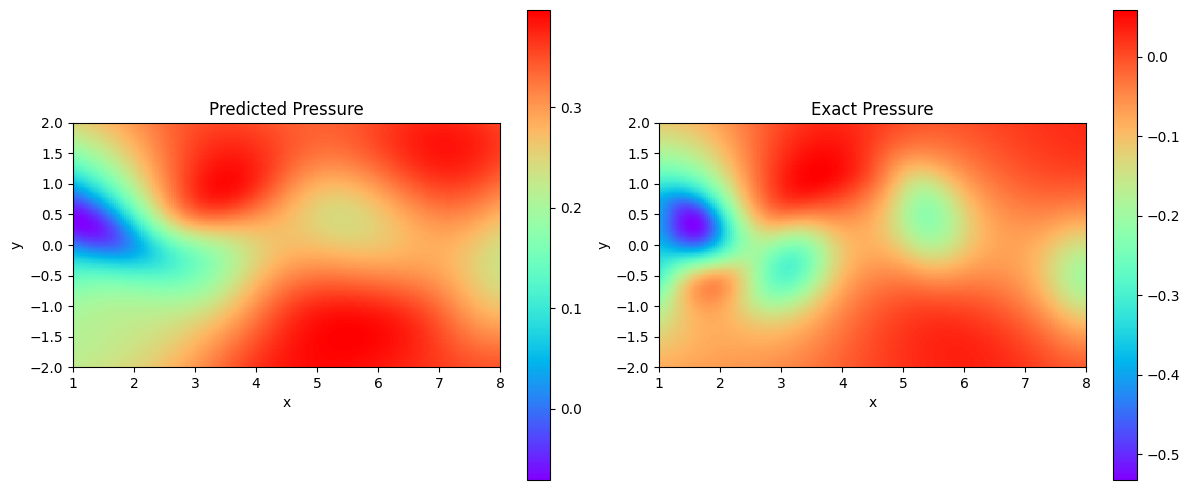


SUMMARY TABLE

Correct PDE:
u_t + (u*u_x + v*u_y) = -p_x + 0.01*(u_xx + u_yy)
v_t + (u*v_x + v*v_y) = -p_y + 0.01*(v_xx + v_yy)

Identified PDE (clean data):
u_t + 0.932*(u*u_x + v*u_y) = -p_x + 0.01862*(u_xx + u_yy)
v_t + 0.932*(u*v_x + v*v_y) = -p_y + 0.01862*(v_xx + v_yy)

Identified PDE (1% noise):
u_t + 0.943*(u*u_x + v*u_y) = -p_x + 0.01693*(u_xx + u_yy)
v_t + 0.943*(u*v_x + v*v_y) = -p_y + 0.01693*(v_xx + v_yy)



In [ ]:
# -----------------------------
# MAIN
# -----------------------------
if __name__ == "__main__":
    # Seed pour la reproductibilité
    np.random.seed(1234)
    torch.manual_seed(1234)

    # Paramètres
    N_train = 1000
    layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]

    # Charger les données
    print("Loading data...")
    data = scipy.io.loadmat("/content/cylinder_nektar_wake.mat")

    U_star = data["U_star"]  # N x 2 x T
    P_star = data["p_star"]  # N x T
    t_star = data["t"]       # T x 1
    X_star = data["X_star"]  # N x 2

    N = X_star.shape[0]
    T = t_star.shape[0]

    # Réorganiser les données
    XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
    YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
    TT = np.tile(t_star, (1, N)).T        # N x T

    UU = U_star[:, 0, :]  # N x T
    VV = U_star[:, 1, :]  # N x T
    PP = P_star           # N x T

    x = XX.flatten()[:, None]  # NT x 1
    y = YY.flatten()[:, None]  # NT x 1
    t = TT.flatten()[:, None]  # NT x 1

    u = UU.flatten()[:, None]  # NT x 1
    v = VV.flatten()[:, None]  # NT x 1
    p = PP.flatten()[:, None]  # NT x 1

    ######################################################################
    ######################## Données sans bruit ##########################
    ######################################################################
    print(f"\n{'='*60}")
    print("TRAINING WITH CLEAN DATA")
    print(f"{'='*60}")

    # Échantillonnage aléatoire pour l'entraînement
    idx = np.random.choice(N * T, N_train, replace=False)
    x_train = torch.tensor(x[idx, :], dtype=torch.float32, requires_grad=True)
    y_train = torch.tensor(y[idx, :], dtype=torch.float32, requires_grad=True)
    t_train = torch.tensor(t[idx, :], dtype=torch.float32, requires_grad=True)
    u_train = torch.tensor(u[idx, :], dtype=torch.float32)
    v_train = torch.tensor(v[idx, :], dtype=torch.float32)

    # Créer et entraîner le modèle
    model = PhysicsInformedNN(layers)
    train(model, x_train, y_train, t_train, u_train, v_train,
          adam_iters=1000, lbfgs_maxiter=1000)

    # Récupérer les valeurs identifiées
    lambda_1_value = model.lambda_1.item()
    lambda_2_value = model.lambda_2.item()

    # Données de test (snapshot 100)
    snap = 100
    x_star = torch.tensor(X_star[:, 0:1], dtype=torch.float32, requires_grad=True).to(device)
    y_star = torch.tensor(X_star[:, 1:2], dtype=torch.float32, requires_grad=True).to(device)
    t_star = torch.tensor(TT[:, snap:snap+1], dtype=torch.float32, requires_grad=True).to(device)

    u_star = U_star[:, 0, snap]
    v_star = U_star[:, 1, snap]
    p_star = P_star[:, snap]

    # Prédiction
    u_pred, v_pred, p_pred = predict(model, x_star, y_star, t_star)
    u_pred = u_pred.cpu().detach().numpy()
    v_pred = v_pred.cpu().detach().numpy()
    p_pred = p_pred.cpu().detach().numpy()

    # Calcul des erreurs
    error_u = np.linalg.norm(u_star - u_pred.flatten(), 2) / np.linalg.norm(u_star, 2)
    error_v = np.linalg.norm(v_star - v_pred.flatten(), 2) / np.linalg.norm(v_star, 2)
    error_p = np.linalg.norm(p_star - p_pred.flatten(), 2) / np.linalg.norm(p_star, 2)

    error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
    error_lambda_2 = np.abs(lambda_2_value - 0.01) / 0.01 * 100

    print(f"\n{'='*60}")
    print("RESULTS - CLEAN DATA")
    print(f"{'='*60}")
    print(f'Error u: {error_u:.3e}')
    print(f'Error v: {error_v:.3e}')
    print(f'Error p: {error_p:.3e}')
    print(f'Error λ1: {error_lambda_1:.5f}%')
    print(f'Error λ2: {error_lambda_2:.5f}%')
    print(f'\nIdentified parameters:')
    print(f'λ1 = {lambda_1_value:.6f} (true value: 1.0)')
    print(f'λ2 = {lambda_2_value:.6f} (true value: 0.01)')

    ######################################################################
    ######################## Données bruitées ############################
    ######################################################################
    print(f"\n{'='*60}")
    print("TRAINING WITH NOISY DATA (1% noise)")
    print(f"{'='*60}")

    noise = 0.01
    u_train_noisy = u_train.cpu().numpy() + noise * np.std(u_train.cpu().numpy()) * np.random.randn(*u_train.shape)
    v_train_noisy = v_train.cpu().numpy() + noise * np.std(v_train.cpu().numpy()) * np.random.randn(*v_train.shape)

    u_train_noisy = torch.tensor(u_train_noisy, dtype=torch.float32)
    v_train_noisy = torch.tensor(v_train_noisy, dtype=torch.float32)

    # Nouveau modèle pour les données bruitées
    model_noisy = PhysicsInformedNN(layers)
    train(model_noisy, x_train, y_train, t_train, u_train_noisy, v_train_noisy,
          adam_iters=1000, lbfgs_maxiter=10000)

    lambda_1_value_noisy = model_noisy.lambda_1.item()
    lambda_2_value_noisy = model_noisy.lambda_2.item()

    error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0) * 100
    error_lambda_2_noisy = np.abs(lambda_2_value_noisy - 0.01) / 0.01 * 100

    print(f"\n{'='*60}")
    print("RESULTS - NOISY DATA")
    print(f"{'='*60}")
    print(f'Error λ1: {error_lambda_1_noisy:.5f}%')
    print(f'Error λ2: {error_lambda_2_noisy:.5f}%')
    print(f'\nIdentified parameters:')
    print(f'λ1 = {lambda_1_value_noisy:.6f} (true value: 1.0)')
    print(f'λ2 = {lambda_2_value_noisy:.6f} (true value: 0.01)')

    ######################################################################
    ########################### Visualisation ############################
    ######################################################################

    # Interpolation pour le plotting
    lb = X_star.min(0)
    ub = X_star.max(0)
    nn = 200
    x_grid = np.linspace(lb[0], ub[0], nn)
    y_grid = np.linspace(lb[1], ub[1], nn)
    X, Y = np.meshgrid(x_grid, y_grid)

    UU_star = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
    VV_star = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')
    PP_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')
    P_exact = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')

    # Plot pressure comparison
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    im0 = ax[0].imshow(PP_star, interpolation='nearest', cmap='rainbow',
                       extent=[lb[0], ub[0], lb[1], ub[1]],
                       origin='lower', aspect='auto')
    plt.colorbar(im0, ax=ax[0])
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].set_title('Predicted Pressure')
    ax[0].set_aspect('equal', 'box')

    im1 = ax[1].imshow(P_exact, interpolation='nearest', cmap='rainbow',
                       extent=[lb[0], ub[0], lb[1], ub[1]],
                       origin='lower', aspect='auto')
    plt.colorbar(im1, ax=ax[1])
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    ax[1].set_title('Exact Pressure')
    ax[1].set_aspect('equal', 'box')

    plt.tight_layout()
    plt.savefig('pressure_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Afficher le tableau récapitulatif
    print(f"\n{'='*60}")
    print("SUMMARY TABLE")
    print(f"{'='*60}")
    print("\nCorrect PDE:")
    print("u_t + (u*u_x + v*u_y) = -p_x + 0.01*(u_xx + u_yy)")
    print("v_t + (u*v_x + v*v_y) = -p_y + 0.01*(v_xx + v_yy)")
    print("\nIdentified PDE (clean data):")
    print(f"u_t + {lambda_1_value:.3f}*(u*u_x + v*u_y) = -p_x + {lambda_2_value:.5f}*(u_xx + u_yy)")
    print(f"v_t + {lambda_1_value:.3f}*(u*v_x + v*v_y) = -p_y + {lambda_2_value:.5f}*(v_xx + v_yy)")
    print("\nIdentified PDE (1% noise):")
    print(f"u_t + {lambda_1_value_noisy:.3f}*(u*u_x + v*u_y) = -p_x + {lambda_2_value_noisy:.5f}*(u_xx + u_yy)")
    print(f"v_t + {lambda_1_value_noisy:.3f}*(u*v_x + v*v_y) = -p_y + {lambda_2_value_noisy:.5f}*(v_xx + v_yy)")
    print(f"{'='*60}\n")
